In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer


from kaggle.settings.constants import DATA_PATH

In [49]:
# Load the data (replace with your actual file paths)
gen1_data = pd.read_csv(DATA_PATH + "gen1_train_comp_final.csv")  #parents
gen2_data = pd.read_csv(DATA_PATH + "gen2_train_comp_final.csv")  #children
gen1_data.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,774,F,0.10,56.961812
1,774,F,0.25,64.826190
2,774,F,0.50,74.340764
3,774,F,0.75,79.747338
4,774,F,1.00,84.092569


In [50]:
print(gen1_data.gen1_id.nunique())
gen1_data.isnull().sum()

101


gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                  310
dtype: int64

In [51]:
gen2_data.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,3012,M,mother,636,0.10,56.251625,4.636903
1,3012,M,mother,636,0.25,64.491579,NaN
2,3012,M,mother,636,0.50,70.465927,NaN
3,3012,M,mother,636,0.75,73.992677,NaN
4,3012,M,mother,636,1.00,79.343537,NaN


In [52]:
print(gen2_data.gen2_id.nunique())
gen2_data.isnull().sum()

192


gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                   512
Wgt_kg                   2045
dtype: int64

In [4]:
merged_data = pd.merge(gen2_data, gen1_data, how='left', left_on="study_parent_id_new", right_on="gen1_id", suffixes=("_child", "_parent"))
print(merged_data.shape)
merged_data.head()

(120494, 11)


,gen2_id,sex_assigned_at_birth_child,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm_child,Wgt_kg,gen1_id,sex_assigned_at_birth_parent,age,SHgt_cm_parent
0,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.10,53.818812
1,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.25,61.276841
2,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.50,68.828343
3,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,0.75,75.452930
4,3012,M,mother,636,0.1,56.251625,4.636903,636.0,M,1.00,77.834870


In [5]:
merged_data.groupby(["gen2_id"]).apply(lambda row: len(set(row["study_parent_sex"]))).value_counts()

/var/folders/lb/pskgtvls62dbtqb4_b8_f_8c0000gn/T/ipykernel_63757/2445472079.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_data.groupby(["gen2_id"]).apply(lambda row: len(set(row["study_parent_sex"]))).value_counts()


1    188
2      4
Name: count, dtype: int64

In [6]:
merged_data.isnull().sum()

gen2_id                             0
sex_assigned_at_birth_child         0
study_parent_sex                    0
study_parent_id_new                 0
AgeGr                               0
SHgt_cm_child                   14407
Wgt_kg                          58045
gen1_id                           902
sex_assigned_at_birth_parent      902
age                               902
SHgt_cm_parent                  11088
dtype: int64

In [7]:
merged_data.describe()

,gen2_id,study_parent_id_new,AgeGr,SHgt_cm_child,Wgt_kg,gen1_id,age,SHgt_cm_parent
count,120494.000000,120494.000000,120494.000000,106087.000000,62449.000000,119592.000000,119592.000000,109406.000000
mean,2664.237904,570.137484,7.140909,118.678885,38.017027,570.629139,10.350000,135.421024
std,100.941558,117.840982,5.646012,37.609424,16.534558,117.209966,6.323429,38.823067
min,1332.000000,262.000000,0.100000,49.896709,4.636903,370.000000,0.100000,50.627457
25%,2579.000000,485.000000,1.500000,84.027467,24.140498,485.000000,4.750000,105.983143
50%,2664.000000,569.000000,6.500000,121.187800,34.147985,569.000000,11.250000,146.424900
75%,2745.000000,663.000000,12.000000,151.362557,50.053202,663.000000,15.625000,166.664428
max,3012.000000,774.000000,18.000000,196.140713,112.812058,774.000000,20.000000,197.081343


In [8]:
merged_data['SHgt_cm_parent'] = (
    merged_data.groupby("gen1_id")['SHgt_cm_parent']
    .apply(lambda x: x.interpolate(method='linear'))
    .reset_index(level=0, drop=True)  # Ensures the index matches merged_data
    .bfill()
)

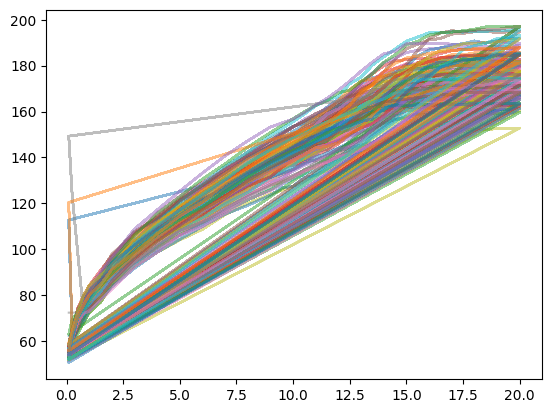

In [9]:
for id in merged_data.gen1_id.unique():
    temp = merged_data[merged_data.gen1_id == id]
    plt.plot(temp["age"].values, temp["SHgt_cm_parent"].values, alpha=0.5)

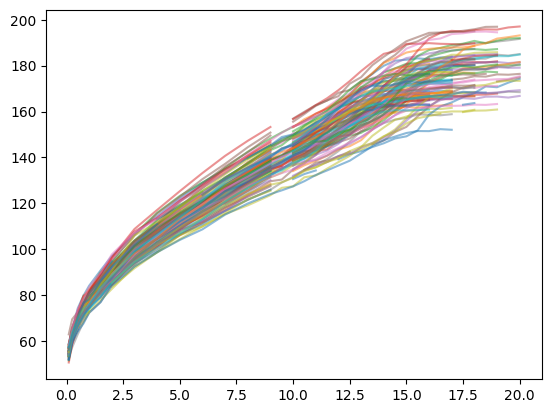

In [14]:
for id in gen1_data.gen1_id.unique():
    temp = gen1_data[gen1_data.gen1_id == id]
    plt.plot(temp["age"].values, temp["SHgt_cm"].values, alpha=0.5)

/var/folders/lb/pskgtvls62dbtqb4_b8_f_8c0000gn/T/ipykernel_63757/1489965635.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("gen1_id", group_keys=False).apply(linear_interpolation_for_specific_range).reset_index(drop=True)


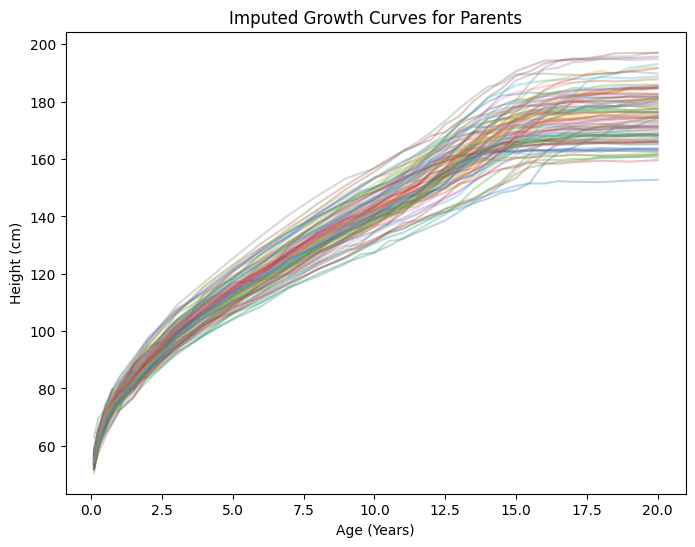

In [44]:
df = gen1_data.copy() 

import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Step 1: Linear Interpolation for Missing Age Range (9-10 years)
def linear_interpolation_for_specific_range(group):
    """Applies linear interpolation only to the 9-10 year age range."""
    mask = (group['age'] >= 9) # & (group['age'] <= 10)
    
    # Interpolate only within the specified age range
    group.loc[mask, 'SHgt_cm'] = group.loc[mask, 'SHgt_cm'].interpolate(method='linear')
    
    return group

# Ensure 'gen1_id' remains a column, not an index
df = df.groupby("gen1_id", group_keys=False).apply(linear_interpolation_for_specific_range).reset_index(drop=True)

# Step 2: KNN Imputation for Random Missing Values (outside 9-10 age range)
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")  # 5 nearest neighbors
knn_data = df[['age', 'SHgt_cm']]
df['SHgt_cm_parent'] = knn_imputer.fit_transform(knn_data)[:, 1]

# Step 3: Mean Imputation for Parents with Only First & Last Values
mean_height_by_age = df.groupby("age")['SHgt_cm_parent'].transform(lambda x: x.fillna(x.mean()))
df['SHgt_cm_parent'] = df['SHgt_cm_parent'].fillna(mean_height_by_age)

# Step 4: Drop Parents with Extremely Sparse Data (Fewer than 3 Observations)
parent_counts = df.groupby("gen1_id")['SHgt_cm_parent'].count()
valid_parents = parent_counts[parent_counts >= 3].index
df = df[df['gen1_id'].isin(valid_parents)]

# Plot the imputed growth curves for visualization
plt.figure(figsize=(8,6))
for parent_id, group in df.groupby("gen1_id"):
    plt.plot(group["age"], group["SHgt_cm_parent"], alpha=0.3)

plt.xlabel("Age (Years)")
plt.ylabel("Height (cm)")
plt.title("Imputed Growth Curves for Parents")
plt.show()

In [45]:
df.gen1_id.nunique()

101

In [46]:
df.isnull().sum()

gen1_id                   0
sex_assigned_at_birth     0
age                       0
SHgt_cm                  27
SHgt_cm_parent            0
dtype: int64

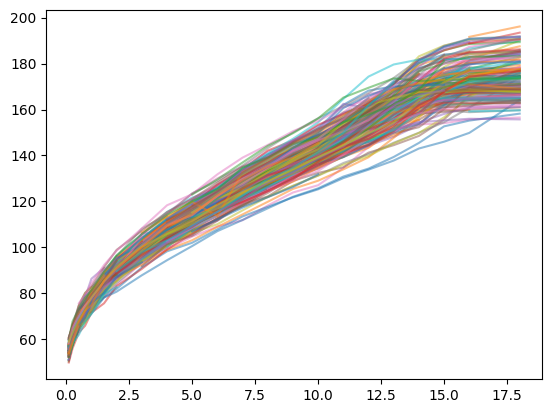

In [13]:
for id in gen2_data.gen2_id.unique():
    temp = gen2_data[gen2_data.gen2_id == id]
    plt.plot(temp["AgeGr"].values, temp["SHgt_cm"].values, alpha=0.5)

In [12]:
gen2_data['SHgt_cm_parent'] = (
    gen2_data.groupby("gen2_id")['SHgt_cm']
    .apply(lambda x: x.interpolate(method='polynomial', order = 2))
    .reset_index(level=0, drop=True)  # Ensures the index matches merged_data
    .bfill()
)

for id in gen2_data.gen2_id.unique():
    temp = gen2_data[gen2_data.gen2_id == id]
    plt.plot(temp["AgeGr"].values, temp["SHgt_cm_parent"].values, alpha=0.5)

ValueError: The number of derivatives at boundaries does not match: expected 1, got 0+0

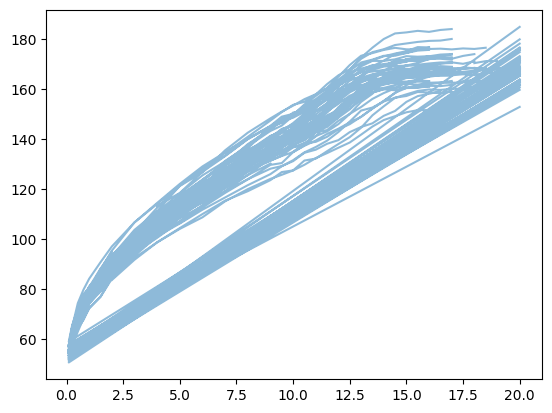

In [63]:
m = gen1_data[gen1_data["sex_assigned_at_birth"] == "M"]
f = gen1_data[gen1_data["sex_assigned_at_birth"] == "F"]
plt.plot(f["age"].values, f["SHgt_cm"].values, alpha=0.5)

In [42]:
gen1_data = gen1_data.sort_values(by = ["gen1_id", "age"])
gen1_data_grouped = gen1_data.groupby("gen1_id")
gen1_data["SHgt_cm_CLEANED"] = gen1_data_grouped["SHgt_cm"].apply(lambda x: x.interpolate(method="linear")).bfill().values

gen2_data = gen2_data.sort_values(by = ["gen2_id", "AgeGr"])
gen2_data_grouped = gen2_data.groupby("gen2_id")
gen2_data["SHgt_cm_CLEANED"] = gen2_data_grouped["SHgt_cm"].apply(lambda x: x.interpolate(method="linear")).bfill().values
gen2_data["Wgt_kg_CLEANED"] = gen2_data_grouped["Wgt_kg"].apply(lambda x: x.interpolate(method="linear")).bfill().values

In [43]:
gen1_data[gen1_data["SHgt_cm_CLEANED"].isna()]

,gen1_id,sex_assigned_at_birth,age,SHgt_cm,SHgt_cm_CLEANED


In [44]:
# gen1_data[gen1_data["gen1_id"]==489]

In [45]:
gen1_data.describe()

,gen1_id,age,SHgt_cm,SHgt_cm_CLEANED
count,3636.00000,3636.000000,3326.000000,3636.000000
mean,574.80198,10.350000,135.439189,137.447983
std,114.14434,6.324272,38.831436,38.544494
min,370.00000,0.100000,50.627457,50.627457
25%,490.00000,4.750000,105.990771,109.724534
50%,569.00000,11.250000,146.593052,148.799857
75%,679.00000,15.625000,166.793640,168.120945
max,774.00000,20.000000,197.081343,197.081343


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'SHgt_cm'}>]], dtype=object)

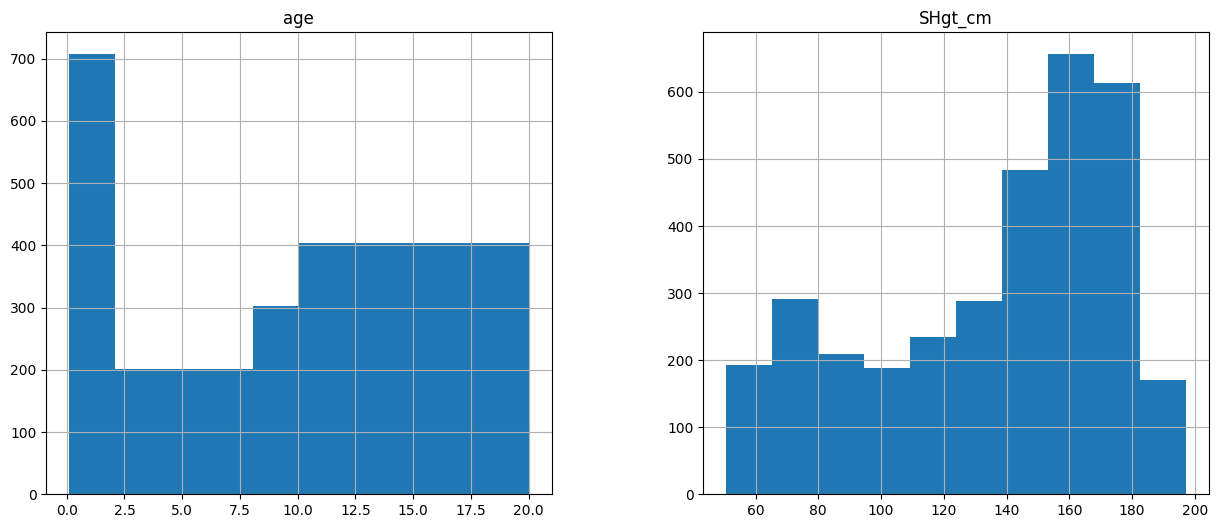

In [46]:
gen1_data[['age', 'SHgt_cm']].hist(figsize=(15, 6))

In [47]:
gen2_data.describe()

,gen2_id,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,SHgt_cm_CLEANED,Wgt_kg_CLEANED
count,4224.000000,4224.000000,4224.000000,3712.000000,2179.000000,4224.000000,4224.000000
mean,2650.552083,556.604167,7.140909,118.697202,38.362150,117.183559,29.568137
std,139.645270,133.354678,5.646657,37.809589,16.880285,37.757088,16.099834
min,1332.000000,262.000000,0.100000,49.896709,4.636903,49.896709,4.636903
25%,2574.500000,453.250000,1.500000,83.766677,24.263125,82.666230,18.081623
50%,2648.500000,550.500000,6.500000,121.085655,34.270051,117.525367,21.803635
75%,2736.250000,668.000000,12.000000,151.367367,50.468043,150.386736,37.549897
max,3012.000000,774.000000,18.000000,196.140713,112.812058,196.140713,112.812058


array([[<Axes: title={'center': 'AgeGr'}>,
        <Axes: title={'center': 'SHgt_cm'}>],
       [<Axes: title={'center': 'Wgt_kg'}>, <Axes: >]], dtype=object)

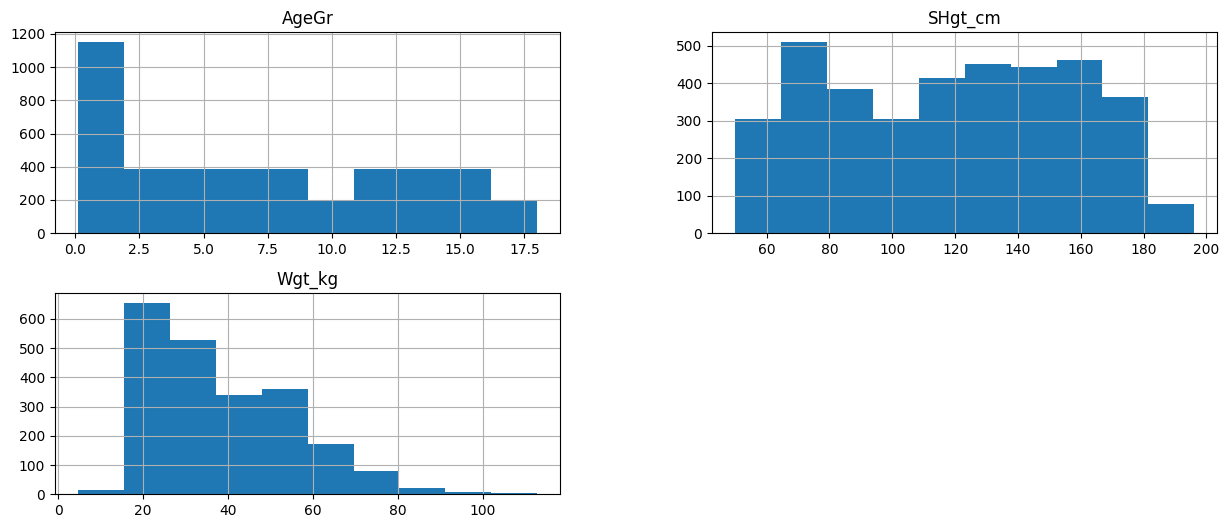

In [48]:
gen2_data[['AgeGr', 'SHgt_cm', 'Wgt_kg']].hist(figsize=(15, 6))

In [49]:
# Merge parent and child data
merged_data = pd.merge(gen2_data, gen1_data, how='left', left_on="study_parent_id_new", right_on="gen1_id", suffixes=("_child", "_parent"))
merged_data

,gen2_id,sex_assigned_at_birth_child,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm_child,Wgt_kg,SHgt_cm_CLEANED_child,Wgt_kg_CLEANED,gen1_id,sex_assigned_at_birth_parent,age,SHgt_cm_parent,SHgt_cm_CLEANED_parent
0,1332,F,mother,724,0.10,54.098866,NaN,54.098866,18.839206,NaN,NaN,NaN,NaN,NaN
1,1332,F,mother,724,0.25,59.128432,NaN,59.128432,18.839206,NaN,NaN,NaN,NaN,NaN
2,1332,F,mother,724,0.50,67.256015,NaN,67.256015,18.839206,NaN,NaN,NaN,NaN,NaN
3,1332,F,mother,724,0.75,72.511388,NaN,72.511388,18.839206,NaN,NaN,NaN,NaN,NaN
4,1332,F,mother,724,1.00,74.886310,NaN,74.886310,18.839206,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120489,3012,M,father,636,18.00,183.923713,78.542122,183.923713,78.542122,636.0,M,18.0,180.441848,180.441848
120490,3012,M,father,636,18.00,183.923713,78.542122,183.923713,78.542122,636.0,M,18.5,NaN,180.208484
120491,3012,M,father,636,18.00,183.923713,78.542122,183.923713,78.542122,636.0,M,19.0,179.975120,179.975120
120492,3012,M,father,636,18.00,183.923713,78.542122,183.923713,78.542122,636.0,M,19.5,NaN,180.359929


In [50]:
gen1_data.shape

(3636, 5)

In [51]:
gen2_data.shape

(4224, 9)

In [52]:
merged_data.shape

(120494, 14)